In [1]:
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import Pool

from algorithms.C45 import C45
from algorithms.ID3 import ID3
from algorithms.RandomForest import RandomForest
from algorithms.SklearnModel import SklearnModel
from utils import load_gender_dataset, load_car_dataset
import warnings
from typing import Tuple, Dict, List, Callable, Any, Iterable
warnings.filterwarnings('ignore')

In [2]:
def main() -> None:
    df, discrete_columns = load_gender_dataset()

    X, Y = df.drop(columns=['target']), df['target']

    classifiers = [
        # ('ID3', ID3(max_depth=5, features_to_use=list(set(discrete_columns.keys())))),
        # ('C45',
        #  C45(max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0, random_state=42)),
        ('DecisionTree', SklearnModel(DecisionTreeClassifier, max_depth=50, discrete_feature_order=discrete_columns)),
        ('RandomForestC45', RandomForest(
            n_estimators=20,
            tree_constructor=partial(SklearnModel, DecisionTreeClassifier, max_depth=50, discrete_feature_order=discrete_columns),
            # tree_constructor=partial(C45, max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0),
            max_features=6, bootstrap_fraction=0.8)),
        ('RandomForestC45_noweighting', RandomForest(
            n_estimators=20,
            tree_constructor=partial(SklearnModel, DecisionTreeClassifier, max_depth=50,
                                     discrete_feature_order=discrete_columns),
            # tree_constructor=partial(C45, max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0),
            max_features=6, bootstrap_fraction=0.8, sampling_temperature=0)),
    ]

    accuracies = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for name, clf in classifiers:
        accuracies.append([])
        for train_idx, val_idx in skf.split(X, Y):
            clf.fit(X.iloc[train_idx], Y.iloc[train_idx])
            Y_pred = clf.predict(X.iloc[val_idx])
            accuracy = accuracy_score(Y.iloc[val_idx], Y_pred)
            accuracies[-1].append(accuracy)
        print(f"{name} Accuracy: {np.mean(accuracies[-1]):.4f} +/- {np.std(accuracies[-1]):.4f}")

    names, acc_values = zip(*classifiers)
    plt.figure(figsize=(15, 5))
    sns.barplot(data=pd.DataFrame([(name, acc) for name, accs in zip(names, accuracies) for acc in accs]), x=0, y=1)
    plt.ylabel('Accuracy')
    plt.title('Comparison of Classifier Accuracies on the Gender Classification Dataset')

In [3]:
main()

DecisionTree Accuracy: 0.9640 +/- 0.0057


KeyboardInterrupt: 

## Dodatkowe funkcje

### Load Dataset

In [2]:
def load_dataset(dataset_name: str):
    if dataset_name == 'gender':
        df, cols = load_gender_dataset()
        target_column = 'target'
    elif dataset_name == 'car':
        df, cols = load_car_dataset()
        target_column = 'target'
    else:
        raise ValueError("Invalid dataset name. Choose either 'gender' or 'car'.")
    return df, cols

### Data Split

In [3]:
def data_split(df, val_fraction, stratification_target='target', seed=0):
    """
    Returns a tuple (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs = []
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)
        val_indices = indices[:round(val_fraction * len(indices))]
        train_indices = indices[round(val_fraction * len(indices)):]

        train_dfs.append(df_group.iloc[train_indices])
        val_dfs.append(df_group.iloc[val_indices])

    return pd.concat(train_dfs), pd.concat(val_dfs)

### Cross Validation

In [4]:
def cross_validation_split(df, split_count, stratification_target="target", seed=0):
    """
    Cross validation function
    Returns a list of tuples (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs: List[List[pd.DataFrame]] = []  # train_dfs[stratification_target_index][split_number]
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)

        train_dfs.append([])
        val_dfs.append([])
        for split_number in range(split_count):
            # len(indices) / split_count -- approximated elements in one chunk
            val_start = round(split_number * len(indices) / split_count)
            val_end = round((split_number + 1) * len(indices) / split_count)
            val_indices = indices[val_start:val_end]
            train_indices = np.concatenate((indices[:val_start], indices[val_end:]))

            train_dfs[-1].append(df_group.iloc[train_indices])
            val_dfs[-1].append(df_group.iloc[val_indices])

    return [
        (pd.concat([dfs[i] for dfs in train_dfs]), pd.concat([dfs[i] for dfs in val_dfs])) for i in range(split_count)
    ]

### Calculate Macro Accuracy 

In [5]:
def macro_accuracy(ground_truth, y_pred):
    cm = confusion_matrix(ground_truth, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    macro_accuracy = np.mean(class_accuracies)
    
    return macro_accuracy

### Show Report

In [6]:
def show_report(data: Dict[str, np.ndarray], dfname: str, name=""):
    """
    data[split_name] -> (ground_truth, predictions)
    where ground_truth and predictions have shape either (num_reps x num_samples) or (num_samples)
    Plots confusion matrix and bar plot(contains metrics and values of them) 
    """
    # map ground truths and predictions to 2d np.array if they are 1d.
    data = {k: tuple(map(lambda v: (v if len(v.shape) == 2 else v.reshape(1, -1)), vs)) for k, vs in data.items()}
    
    plt.figure(figsize=(20, 5 * len(data)))
    plt.suptitle(name)
    
    for i, (split, (ground_truth, preds)) in enumerate(data.items()):
        ax = plt.subplot(len(data), 2, 1 + 2 * i)
        plt.title(split)
        ConfusionMatrixDisplay.from_predictions(ground_truth.reshape(-1), preds.reshape(-1), normalize="all", ax=ax)
    
    plt.subplot(1, 2, 2)
    if dfname == "gender":
        metrics = [
        (accuracy_score, "accuracy"),
        (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        # (lambda *args: precision_score(*args, pos_label=["Female", "Male"]), "precision"),
        # (lambda *args: recall_score(*args, pos_label=["Female", "Male"]), "recall"),
        # (lambda *args: f1_score(*args, pos_label=["Female", "Male"]), "f1"),
    ]
    if dfname == "car":
        metrics = [
            (accuracy_score, "accuracy"),
            (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        ]

    df = pd.DataFrame.from_dict(
        {
            "value": [
                metric(gt[i], preds[i])
                for metric, _ in metrics
                for split, (gt, preds) in data.items()
                for i, _ in enumerate(gt)
            ],
            "split": [split for _, _ in metrics for split, (gt, _) in data.items() for _ in gt],
            "metric": [metric_name for _, metric_name in metrics for _, (gt, _) in data.items() for _ in gt],
        }
    )
    sns.barplot(df, x="metric", y="value", hue="split", errorbar='sd')

    plt.show()

## Szukanie najlepszych hiperparametrów

In [7]:
def display_plot(summary, title):
    '''
    Displays two plots with metrics: train_accuracy, train_loss, val_accuracy, val_loss for
    each calculates a value of loss function and displays it for epochs.
    '''
    plt.figure(figsize=(20, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.lineplot(summary[['loss' in m for m in summary.metric]], x='epoch', y='value', hue='metric', errorbar='sd')
    plt.subplot(1, 2, 2)
    sns.lineplot(summary[['accuracy' in m for m in summary.metric]], x='epoch', y='value', hue='metric', errorbar='sd')
    plt.show()

In [8]:
def evaluate_model(X, Y, model_constructor, model_args, n_splits=5, verbose=True):
    '''
    Main evaluate model function, uses CROSS-VALIDATE algorithm and fits model,
    displays plot according to fitted model, finally returns accuracy
    '''
    preds = []
    gt = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_args['random_seed'])
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = model_constructor(**model_args)
        model.fit(X.iloc[train_indices], Y.iloc[train_indices])
        preds.append(model.predict(X.iloc[val_indices]))
        gt.append(Y.iloc[val_indices])

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(gt, preds, normalize="all")
    return (preds == gt).mean()

In [9]:
def random_search(X, Y, iterations, reps, pool=__builtins__):
    '''
    performs a random search to find best hyperparameters for the model.
    `iterations` different hyperparameters are randomized, and evaluated `reps` times (with different random seeds)
    returns best hyperparameters and accuracy
    '''
    args = [
        dict(learning_rate=10 ** np.random.normal(-1.5, 1),
             hidden_sizes=[round(2 ** np.random.randint(0, 8)) for _ in range(np.random.randint(0, 4))],
             batch_size=np.random.randint(1, 32),
             num_epochs=np.random.randint(1, 10))
        for i in range(iterations)
    ]
    accs = np.array([
        pool.map(partial(evaluate_model, X, Y, verbose=False), [a | {'random_seed': j} for a in args])
        for j in range(reps)
    ])
    accs = accs.mean(0)
    i = accs.argmax()
    return args[i], accs[i]

In [30]:
def plot_factor_dependency(X, Y, model_constructor, name, values, default_args, reps=5, xlog=False, pool=__builtins__, show=True):

    res = {name: [], 'accuracy': []}
    for arg in values:
        args = default_args.copy()
        args[name] = arg
        
        for accuracy in pool.map(partial(evaluate_model, X, Y, model_constructor, verbose=False), [args | {'random_seed': i} for i in range(reps)]):
            if isinstance(arg, float):
                res[name].append(arg)
            else:
                res[name].append(str(arg))
            res['accuracy'].append(accuracy)

    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='accuracy', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='accuracy', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linnii
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={row[name]} with average accuracy {row["accuracy"] * 100:.2f}%')
    if show:
        plt.show()

In [11]:
df, columns = load_dataset('gender')
X, Y = df.drop(columns='target'), df['target']

def id3_constructor(random_seed, **kwargs): 
    return ID3(features_to_use=list(columns.keys()), **kwargs)

def c45_constructor(**kwargs):
    return C45(discrete_features=list(columns.keys()), **kwargs)

def tree_constructor(kind, **kwargs):
    if kind == 'id3':
        return id3_constructor(**kwargs)
    elif kind == 'c45':
        return c45_constructor(**kwargs)
    else:
        assert 0
        
def rf_constructor(tree_kwargs, random_seed, **kwargs):
    return RandomForest(**kwargs, tree_constructor=lambda: tree_constructor(**tree_kwargs, random_seed=random_seed))

### Maximum Depth

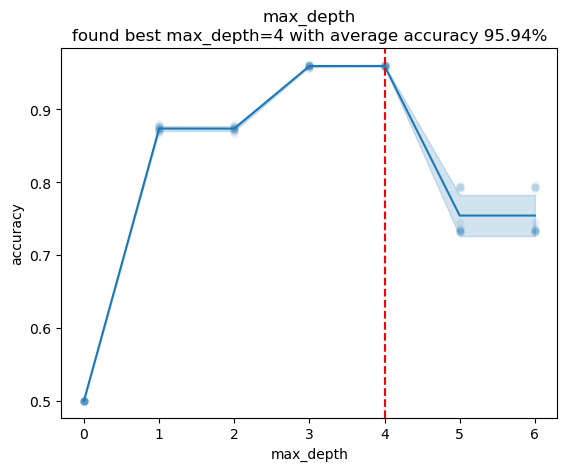

In [27]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, id3_constructor, 'max_depth', range(7), {}, reps=24, pool=pool)

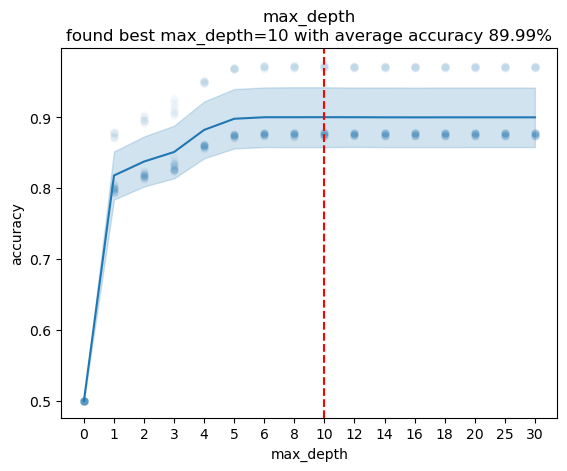

In [14]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'max_depth', [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30], {}, reps=24, pool=pool)

### Validation Ratio

In [ ]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'validation_ratio', np.linspace(0, 0.5, 6), {'max_depth': 10}, reps=24, pool=pool)

### Number of estimators

In [ ]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 4}},
                           reps=24, pool=pool)

In [ ]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': }},
                           reps=24, pool=pool)

### Bootstrap fraction

### Sampling Temperature

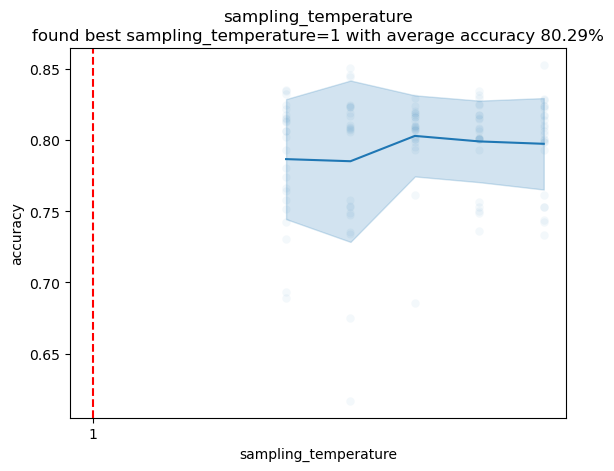

In [25]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0.6, 0.8, 1, 1.2, 1.4],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 0.7, 'tree_kwargs': {'kind': 'id3', 'max_depth': 4}},
                           reps=24, pool=pool)

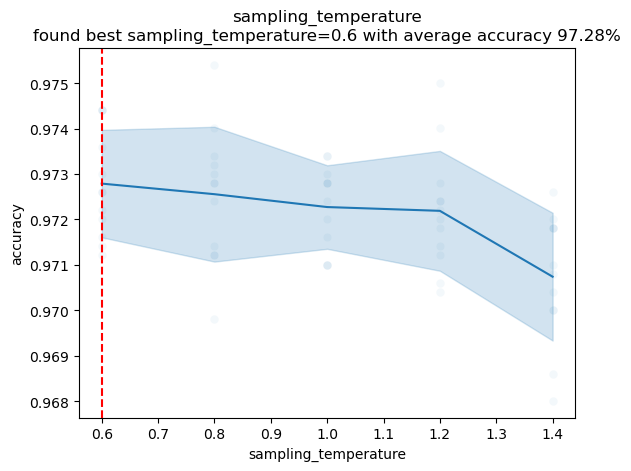

In [21]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 0.7, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10}},
                           reps=24, pool=pool)